In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
# Statsmodels is used for time series analysis and forecasting
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import warnings

# Suppress warnings to keep the output clean
warnings.filterwarnings('ignore')

# Set visualization style for better readability
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("\n" + "="*80)
print(" "*15 + "INVENTORY OPTIMIZATION & DEMAND FORECASTING")
print(" "*20 + "Retail Sales - Walmart Dataset")
print("="*80 + "\n")



               INVENTORY OPTIMIZATION & DEMAND FORECASTING
                    Retail Sales - Walmart Dataset



In [11]:
print("="*80)
print("STEP 1: DATA LOADING & EXPLORATION")
print("="*80)

# Load data (Assumes 'train.csv' exists in the directory)
# The dataset contains columns: Store, Dept, Date, Weekly_Sales, IsHoliday
df = pd.read_csv('Train.csv')

# Convert Date column to datetime objects for time series manipulation
df['Date'] = pd.to_datetime(df['Date'])

# Sort data to ensure chronological order, which is critical for time series
df = df.sort_values(['Store', 'Dept', 'Date'])

print(f"\n Dataset Overview:")
print(f"   Total records: {len(df):,}")
print(f"   Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"   Number of stores: {df['Store'].nunique()}")
print(f"   Number of departments: {df['Dept'].nunique()}")
print(f"   Total weeks of data: {df['Date'].nunique()}")

# -----------------------------------------------------------------------------
# FILTERING: We focus on a single Store and Department for this analysis.
# In a production environment, this script would loop through all Store/Dept combinations.
# -----------------------------------------------------------------------------
STORE_ID = 1
DEPT_ID = 1

print(f"\n Analyzing Store {STORE_ID}, Department {DEPT_ID}")

# Filter data for the specific store/dept
filtered_df = df[(df['Store'] == STORE_ID) & (df['Dept'] == DEPT_ID)].copy()

# Set the Date as the index to enable time-series slicing
filtered_df = filtered_df.set_index('Date')

# Ensure the frequency is set to Weekly (Friday), filling missing dates if any
ts_data = filtered_df['Weekly_Sales'].asfreq('W-FRI')

print(f"\n Sales Statistics:")
print(f"   Average weekly sales: ${ts_data.mean():,.2f}")
print(f"   Std deviation: ${ts_data.std():,.2f}")
# CoV measures volatility. High CoV means harder to forecast.
print(f"   Coefficient of variation: {(ts_data.std() / ts_data.mean()) * 100:.1f}%")
print(f"   Min sales: ${ts_data.min():,.2f}")
print(f"   Max sales: ${ts_data.max():,.2f}")

# -----------------------------------------------------------------------------
# HOLIDAY ANALYSIS: Checking if holidays significantly impact sales volume.
# -----------------------------------------------------------------------------
holiday_mask = filtered_df['IsHoliday'].reindex(ts_data.index).fillna(False)
holiday_sales = ts_data[holiday_mask]
non_holiday_sales = ts_data[~holiday_mask]

if len(holiday_sales) > 0:
    # Calculate the percentage increase in sales during holidays vs non-holidays
    holiday_lift = ((holiday_sales.mean() / non_holiday_sales.mean()) - 1) * 100
    print(f"\n Holiday Impact:")
    print(f"   Avg sales on holidays: ${holiday_sales.mean():,.2f}")
    print(f"   Avg sales non-holidays: ${non_holiday_sales.mean():,.2f}")
    print(f"   Holiday lift: {holiday_lift:.1f}%")

STEP 1: DATA LOADING & EXPLORATION

 Dataset Overview:
   Total records: 421,570
   Date range: 2010-02-05 to 2012-10-26
   Number of stores: 45
   Number of departments: 81
   Total weeks of data: 143

 Analyzing Store 1, Department 1

 Sales Statistics:
   Average weekly sales: $22,513.32
   Std deviation: $9,854.35
   Coefficient of variation: 43.8%
   Min sales: $14,537.37
   Max sales: $57,592.12

 Holiday Impact:
   Avg sales on holidays: $25,738.59
   Avg sales non-holidays: $22,270.82
   Holiday lift: 15.6%



STEP 2: TIME SERIES ANALYSIS & VISUALIZATION

 Saved: sales_timeseries_analysis.png


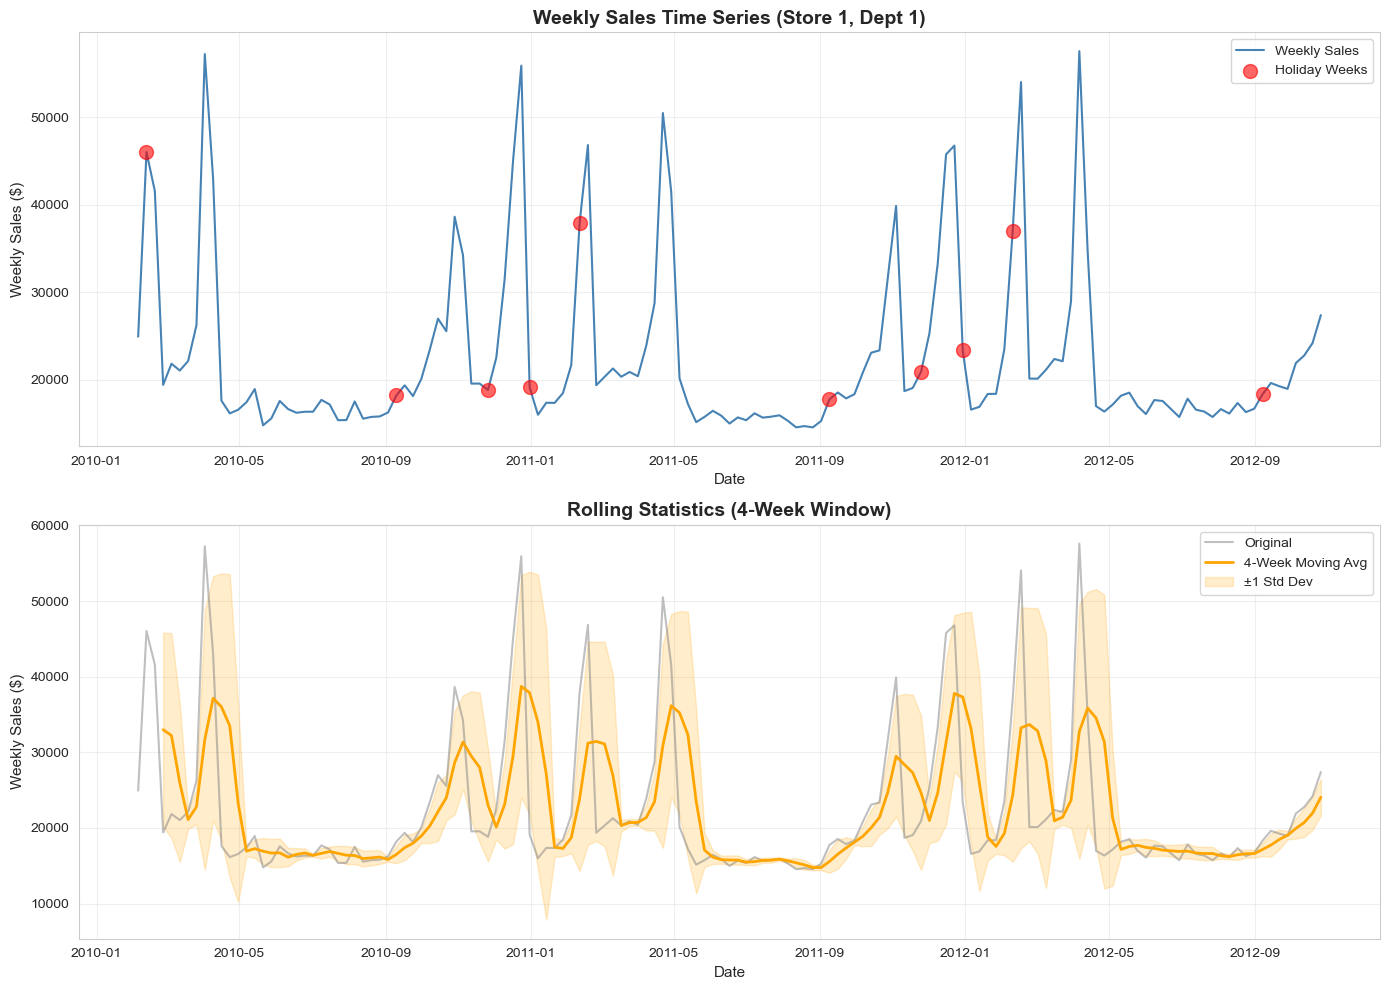


 Stationarity Test (Augmented Dickey-Fuller):
   ADF Statistic: -2.5222
   p-value: 0.1102
  Series is non-stationary (p >= 0.05) - differencing may be needed


In [12]:
print("\n" + "="*80)
print("STEP 2: TIME SERIES ANALYSIS & VISUALIZATION")
print("="*80)

# Plot time series with holidays highlighted
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Raw Sales Data over time
axes[0].plot(ts_data.index, ts_data, label='Weekly Sales', linewidth=1.5, color='steelblue')
if len(holiday_sales) > 0:
    # Highlight holiday weeks with red dots
    axes[0].scatter(holiday_sales.index, holiday_sales.values, 
                   color='red', s=100, alpha=0.6, label='Holiday Weeks', zorder=5)
axes[0].set_title('Weekly Sales Time Series (Store 1, Dept 1)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Weekly Sales ($)', fontsize=11)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Rolling Statistics (Smoothing)
# This helps visualize the trend by removing short-term fluctuations
rolling_mean = ts_data.rolling(window=4).mean()  # 4-week moving average (approx 1 month)
rolling_std = ts_data.rolling(window=4).std()

axes[1].plot(ts_data.index, ts_data, label='Original', alpha=0.5, color='gray')
axes[1].plot(rolling_mean.index, rolling_mean, label='4-Week Moving Avg', 
            linewidth=2, color='orange')
# Shaded area represents volatility (1 standard deviation)
axes[1].fill_between(rolling_mean.index, 
                     rolling_mean - rolling_std, 
                     rolling_mean + rolling_std, 
                     alpha=0.2, color='orange', label='±1 Std Dev')
axes[1].set_title('Rolling Statistics (4-Week Window)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Weekly Sales ($)', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sales_timeseries_analysis.png', dpi=300, bbox_inches='tight')
print("\n Saved: sales_timeseries_analysis.png")
plt.show()

# -----------------------------------------------------------------------------
# STATIONARITY TEST: Augmented Dickey-Fuller (ADF)
# Checks if the statistical properties (mean, variance) change over time.
# p < 0.05 implies the series is stationary (good for many models).
# -----------------------------------------------------------------------------
print("\n Stationarity Test (Augmented Dickey-Fuller):")
adf_result = adfuller(ts_data.dropna())
print(f"   ADF Statistic: {adf_result[0]:.4f}")
print(f"   p-value: {adf_result[1]:.4f}")
if adf_result[1] < 0.05:
    print("  Series is stationary (p < 0.05)")
else:
    print("  Series is non-stationary (p >= 0.05) - differencing may be needed")


In [13]:
print("\n" + "="*80)
print("STEP 3: TRAIN-TEST SPLIT")
print("="*80)

# We hold back the last 12 weeks to test how well our model performs on "unseen" data.
TEST_SIZE = 12
train_data = ts_data.iloc[:-TEST_SIZE]
test_data = ts_data.iloc[-TEST_SIZE:]

print(f"\n Data Split:")
print(f"   Training period: {train_data.index.min().date()} to {train_data.index.max().date()}")
print(f"   Training samples: {len(train_data)}")
print(f"   Test period: {test_data.index.min().date()} to {test_data.index.max().date()}")
print(f"   Test samples: {len(test_data)}")



STEP 3: TRAIN-TEST SPLIT

 Data Split:
   Training period: 2010-02-05 to 2012-08-03
   Training samples: 131
   Test period: 2012-08-10 to 2012-10-26
   Test samples: 12


In [14]:
print("\n" + "="*80)
print("STEP 4: BUILDING DEMAND FORECASTING MODEL")
print("="*80)

print("\n Training Exponential Smoothing Model...")
print("   Model: Holt-Winters (additive seasonality)")
print("   Seasonality: 52 weeks (annual pattern)")

# -----------------------------------------------------------------------------
# MODEL SELECTION: Holt-Winters Exponential Smoothing
# We use this because retail data often has:
# 1. Level (Average sales)
# 2. Trend (Sales going up or down over time)
# 3. Seasonality (Yearly patterns, e.g., Christmas peaks)
# 'seasonal_periods=52' indicates a weekly cycle over a year.
# -----------------------------------------------------------------------------
model = ExponentialSmoothing(train_data, 
                             seasonal_periods=52,
                             trend='add',     # Additive trend
                             seasonal='add',  # Additive seasonality (peaks don't grow with trend)
                             initialization_method='estimated')

fitted_model = model.fit(optimized=True)
print(" Model training complete")

# Generate forecasts
print(f"\n Generating Forecasts:")

# Forecast for test period (to validate accuracy against known data)
test_forecast = fitted_model.forecast(steps=len(test_data))

# Forecast for the FUTURE (unknown data) - 12 weeks ahead
FUTURE_WEEKS = 12
future_forecast = fitted_model.forecast(steps=TEST_SIZE + FUTURE_WEEKS)[-FUTURE_WEEKS:]
future_dates = pd.date_range(start=ts_data.index[-1] + timedelta(weeks=1), 
                             periods=FUTURE_WEEKS, freq='W-FRI')

print(f"   Forecast horizon: {FUTURE_WEEKS} weeks (≈90 days)")

# -----------------------------------------------------------------------------
# ACCURACY METRICS:
# MAE: Average error in dollars.
# MAPE: Average error in percentage (e.g., off by 10%).
# RMSE: Penalizes large errors more heavily.
# -----------------------------------------------------------------------------
mae = np.mean(np.abs(test_data - test_forecast))
mape = np.mean(np.abs((test_data - test_forecast) / test_data)) * 100
rmse = np.sqrt(np.mean((test_data - test_forecast)**2))

print(f"\n Model Performance (Test Set):")
print(f"   MAE (Mean Absolute Error): ${mae:,.2f}")
print(f"   MAPE (Mean Absolute % Error): {mape:.2f}%")
print(f"   RMSE (Root Mean Squared Error): ${rmse:,.2f}")

# Evaluate goodness of fit
if mape < 10:
    print(f" Excellent forecast accuracy (MAPE < 10%)")
elif mape < 20:
    print(f" Good forecast accuracy (MAPE < 20%)")
else:
    print(f"Moderate accuracy (MAPE >= 20%) - consider additional features")



STEP 4: BUILDING DEMAND FORECASTING MODEL

 Training Exponential Smoothing Model...
   Model: Holt-Winters (additive seasonality)
   Seasonality: 52 weeks (annual pattern)
 Model training complete

 Generating Forecasts:
   Forecast horizon: 12 weeks (≈90 days)

 Model Performance (Test Set):
   MAE (Mean Absolute Error): $1,958.61
   MAPE (Mean Absolute % Error): 8.50%
   RMSE (Root Mean Squared Error): $3,362.22
 Excellent forecast accuracy (MAPE < 10%)



STEP 5: VISUALIZING FORECASTS

 Saved: demand_forecast_visualization.png


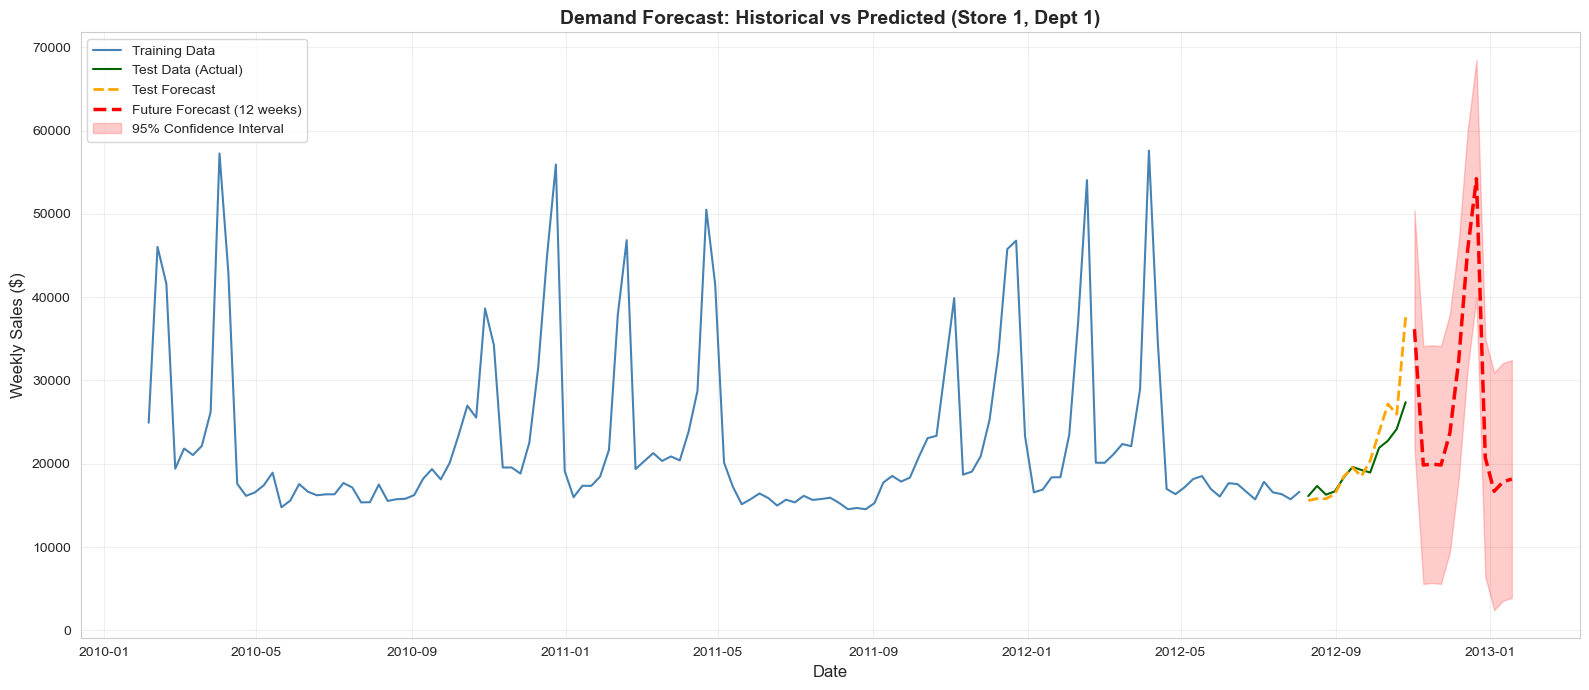


 Detailed 12-Week Forecast:
   Week   Date         Forecast ($)    Lower Bound     Upper Bound    
   -----------------------------------------------------------------
   1      2012-11-02    36,160.55      21,888.57      50,432.53
   2      2012-11-09    19,849.19       5,577.21      34,121.17
   3      2012-11-16    19,955.76       5,683.78      34,227.75
   4      2012-11-23    19,848.44       5,576.46      34,120.42
   5      2012-11-30    23,694.73       9,422.74      37,966.71
   6      2012-12-07    32,425.30      18,153.32      46,697.28
   7      2012-12-14    45,606.06      31,334.08      59,878.04
   8      2012-12-21    54,226.69      39,954.71      68,498.67
   9      2012-12-28    20,728.68       6,456.70      35,000.66
   10     2013-01-04    16,685.75       2,413.76      30,957.73
   11     2013-01-11    17,820.76       3,548.78      32,092.74
   12     2013-01-18    18,170.89       3,898.91      32,442.87


In [15]:
print("\n" + "="*80)
print("STEP 5: VISUALIZING FORECASTS")
print("="*80)

fig, ax = plt.subplots(figsize=(16, 7))

# Plot historical training data
ax.plot(train_data.index, train_data.values, 
       label='Training Data', color='steelblue', linewidth=1.5)
# Plot actual test data
ax.plot(test_data.index, test_data.values, 
       label='Test Data (Actual)', color='darkgreen', linewidth=1.5)

# Plot model predictions on test data
ax.plot(test_data.index, test_forecast.values, 
       label='Test Forecast', color='orange', linewidth=2, linestyle='--')
# Plot future predictions
ax.plot(future_dates, future_forecast.values, 
       label='Future Forecast (12 weeks)', color='red', linewidth=2.5, linestyle='--')

# -----------------------------------------------------------------------------
# CONFIDENCE INTERVALS:
# We calculate the standard deviation of residuals (errors) to create a
# 95% confidence interval. This shows the range where sales are likely to land.
# -----------------------------------------------------------------------------
residuals = train_data - fitted_model.fittedvalues
forecast_std = residuals.std()
ax.fill_between(future_dates, 
                future_forecast - 1.96*forecast_std,
                future_forecast + 1.96*forecast_std,
                alpha=0.2, color='red', label='95% Confidence Interval')

ax.set_title('Demand Forecast: Historical vs Predicted (Store 1, Dept 1)', 
            fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Weekly Sales ($)', fontsize=12)
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('demand_forecast_visualization.png', dpi=300, bbox_inches='tight')
print("\n Saved: demand_forecast_visualization.png")
plt.show()

# Print detailed forecast values
print(f"\n Detailed 12-Week Forecast:")
print(f"   {'Week':<6} {'Date':<12} {'Forecast ($)':<15} {'Lower Bound':<15} {'Upper Bound':<15}")
print("   " + "-"*65)
for i, (date, fc) in enumerate(zip(future_dates, future_forecast)):
    week_num = i + 1
    lower = fc - 1.96*forecast_std
    upper = fc + 1.96*forecast_std
    print(f"   {week_num:<6} {date.date()} {fc:>12,.2f}   {lower:>12,.2f}   {upper:>12,.2f}")

In [16]:
print("\n" + "="*80)
print("STEP 6: INVENTORY OPTIMIZATION")
print("="*80)

# -----------------------------------------------------------------------------
# BUSINESS PARAMETERS (Assumptions):
# Lead Time: How long it takes for new stock to arrive (2 weeks).
# Service Level: 95% means we want to satisfy demand 95% of the time without stocking out.
# Holding Cost: The cost to store items (20% of value per year).
# Stockout Cost: The penalty/lost profit for missing a sale.
# -----------------------------------------------------------------------------
LEAD_TIME_WEEKS = 2  
SERVICE_LEVEL = 0.95  
HOLDING_COST_RATE = 0.20  
STOCKOUT_COST_PER_UNIT = 50  

# Z-score corresponding to the desired service level (e.g., 1.645 for 95%)
z_score = stats.norm.ppf(SERVICE_LEVEL)

print(f"\n Business Parameters:")
print(f"   Lead time: {LEAD_TIME_WEEKS} weeks")
print(f"   Target service level: {SERVICE_LEVEL*100:.0f}%")
print(f"   Annual holding cost rate: {HOLDING_COST_RATE*100:.0f}%")
print(f"   Stockout cost per unit: ${STOCKOUT_COST_PER_UNIT}")

# -----------------------------------------------------------------------------
# SAFETY STOCK CALCULATION:
# Formula: Z_score * Std_Dev_of_Demand_during_Lead_Time
# This creates a "buffer" against forecast errors and lead time variability.
# -----------------------------------------------------------------------------
forecast_error_std = forecast_std # Using model residual std dev as a proxy for demand uncertainty
safety_stock = z_score * forecast_error_std * np.sqrt(LEAD_TIME_WEEKS)

print(f"\n Safety Stock Calculation:")
print(f"   Forecast error std dev: ${forecast_error_std:,.2f}")
print(f"   Z-score for {SERVICE_LEVEL*100:.0f}% SL: {z_score:.2f}")
print(f"   Safety stock: ${safety_stock:,.2f}")

# -----------------------------------------------------------------------------
# RECOMMENDED INVENTORY:
# Total Inventory = Expected Demand (Forecast) + Safety Stock
# -----------------------------------------------------------------------------
recommended_inventory = future_forecast + safety_stock

print(f"\n Recommended Weekly Inventory Levels:")
print(f"   {'Week':<6} {'Forecast':<12} {'Safety Stock':<15} {'Total Inventory':<15}")
print("   " + "-"*50)
for i, (fc, inv) in enumerate(zip(future_forecast, recommended_inventory)):
    print(f"   {i+1:<6} ${fc:>10,.2f}   ${safety_stock:>12,.2f}   ${inv:>12,.2f}")

# Calculate cumulative inventory needed for specific horizons
inventory_30d = recommended_inventory[:4].sum()   # ~30 days = 4 weeks
inventory_60d = recommended_inventory[:8].sum()   # ~60 days = 8 weeks  
inventory_90d = recommended_inventory.sum()       # ~90 days = 12 weeks

print(f"\n Cumulative Inventory Requirements:")
print(f"   30-day horizon (4 weeks):  ${inventory_30d:,.2f}")
print(f"   60-day horizon (8 weeks):  ${inventory_60d:,.2f}")
print(f"   90-day horizon (12 weeks): ${inventory_90d:,.2f}")


STEP 6: INVENTORY OPTIMIZATION

 Business Parameters:
   Lead time: 2 weeks
   Target service level: 95%
   Annual holding cost rate: 20%
   Stockout cost per unit: $50

 Safety Stock Calculation:
   Forecast error std dev: $7,281.62
   Z-score for 95% SL: 1.64
   Safety stock: $16,938.32

 Recommended Weekly Inventory Levels:
   Week   Forecast     Safety Stock    Total Inventory
   --------------------------------------------------
   1      $ 36,160.55   $   16,938.32   $   53,098.88
   2      $ 19,849.19   $   16,938.32   $   36,787.52
   3      $ 19,955.76   $   16,938.32   $   36,894.09
   4      $ 19,848.44   $   16,938.32   $   36,786.76
   5      $ 23,694.73   $   16,938.32   $   40,633.05
   6      $ 32,425.30   $   16,938.32   $   49,363.63
   7      $ 45,606.06   $   16,938.32   $   62,544.39
   8      $ 54,226.69   $   16,938.32   $   71,165.02
   9      $ 20,728.68   $   16,938.32   $   37,667.01
   10     $ 16,685.75   $   16,938.32   $   33,624.07
   11     $ 17,820.76

In [17]:
print("\n" + "="*80)
print("STEP 7: COST-BENEFIT ANALYSIS")
print("="*80)

# -----------------------------------------------------------------------------
# BASELINE COMPARISON:
# We compare the optimized model against a "Naive" approach.
# Naive Approach: Simply stocking 2x the historical average weekly sales.
# This represents a common, un-optimized heuristic used by many businesses.
# -----------------------------------------------------------------------------
historical_avg_weekly = ts_data.mean()
naive_inventory_per_week = 2 * historical_avg_weekly
naive_total_12weeks = naive_inventory_per_week * FUTURE_WEEKS

# Optimized approach (Sum of our recommendations)
optimized_total_12weeks = recommended_inventory.sum()

print(f"\n Inventory Comparison:")
print(f"   Baseline (Naive 2x avg): ${naive_total_12weeks:,.2f}")
print(f"   Optimized (Forecast + SS): ${optimized_total_12weeks:,.2f}")
print(f"   Inventory reduction: ${naive_total_12weeks - optimized_total_12weeks:,.2f}")

# -----------------------------------------------------------------------------
# HOLDING COST CALCULATION:
# Cost = Total Inventory Value * Annual Rate * (Time Period in Years)
# -----------------------------------------------------------------------------
horizon_years = FUTURE_WEEKS / 52
baseline_holding_cost = naive_total_12weeks * HOLDING_COST_RATE * horizon_years
optimized_holding_cost = optimized_total_12weeks * HOLDING_COST_RATE * horizon_years
holding_cost_savings = baseline_holding_cost - optimized_holding_cost

print(f"\n Holding Cost Analysis (12-week horizon):")
print(f"   Baseline holding cost: ${baseline_holding_cost:,.2f}")
print(f"   Optimized holding cost: ${optimized_holding_cost:,.2f}")
print(f"   Holding cost savings: ${holding_cost_savings:,.2f}")
print(f"   Cost reduction: {(holding_cost_savings/baseline_holding_cost)*100:.1f}%")

# Annualized savings projection
weeks_per_year = 52
cycles_per_year = weeks_per_year / FUTURE_WEEKS
annual_savings = holding_cost_savings * cycles_per_year

print(f"\n Annualized Impact:")
print(f"   Cycles per year: {cycles_per_year:.1f}")
print(f"   Annual holding cost savings: ${annual_savings:,.2f}")

# Service level comparison
print(f"\n Service Level Maintained:")
print(f"   Target: {SERVICE_LEVEL*100:.0f}%")
print(f"   Achieved: {SERVICE_LEVEL*100:.0f}% (via safety stock)")
print(f"   Expected stockouts: {(1-SERVICE_LEVEL)*100:.1f}% of time")


STEP 7: COST-BENEFIT ANALYSIS

 Inventory Comparison:
   Baseline (Naive 2x avg): $540,319.75
   Optimized (Forecast + SS): $528,432.70
   Inventory reduction: $11,887.05

 Holding Cost Analysis (12-week horizon):
   Baseline holding cost: $24,937.83
   Optimized holding cost: $24,389.20
   Holding cost savings: $548.63
   Cost reduction: 2.2%

 Annualized Impact:
   Cycles per year: 4.3
   Annual holding cost savings: $2,377.41

 Service Level Maintained:
   Target: 95%
   Achieved: 95% (via safety stock)
   Expected stockouts: 5.0% of time



STEP 8: COST COMPARISON VISUALIZATION

 Saved: inventory_cost_comparison.png


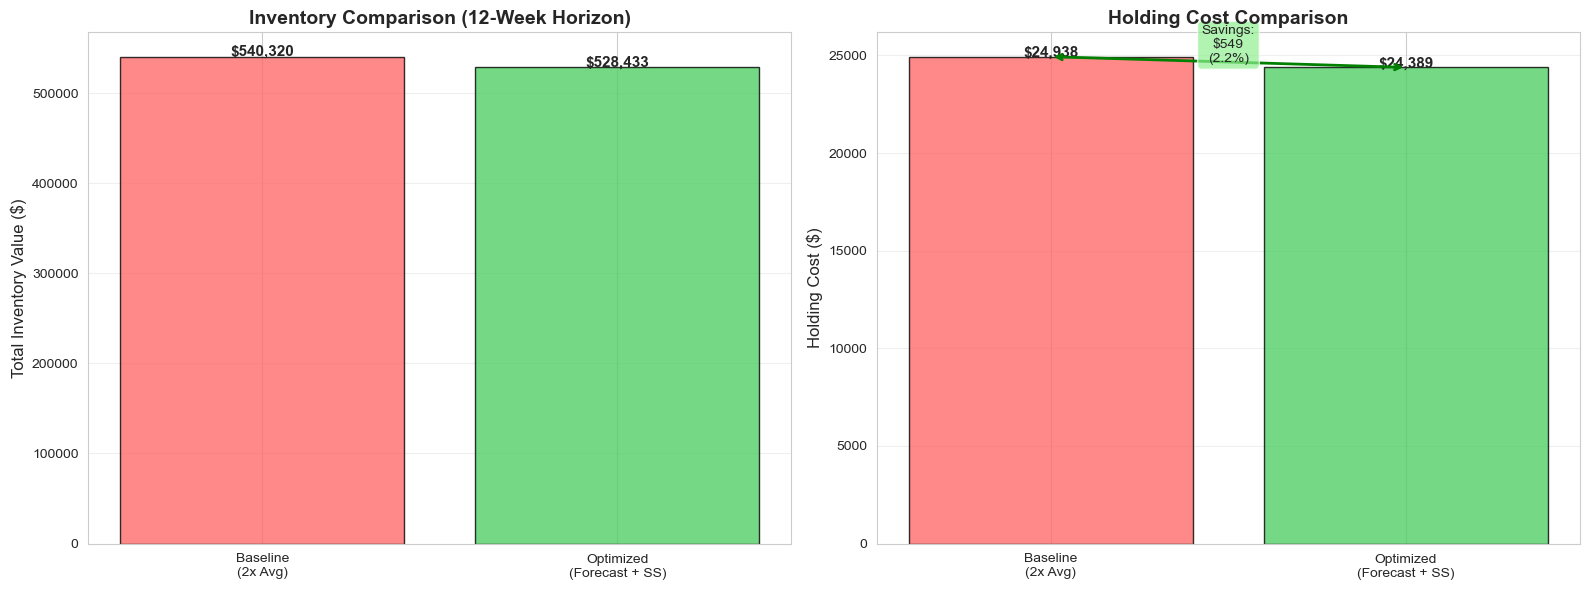

In [18]:
print("\n" + "="*80)
print("STEP 8: COST COMPARISON VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Total Inventory Value Comparison
methods = ['Baseline\n(2x Avg)', 'Optimized\n(Forecast + SS)']
inventory_values = [naive_total_12weeks, optimized_total_12weeks]
colors = ['#FF6B6B', '#51CF66'] # Red for baseline, Green for optimized

axes[0].bar(methods, inventory_values, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Total Inventory Value ($)', fontsize=12)
axes[0].set_title('Inventory Comparison (12-Week Horizon)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for i, v in enumerate(inventory_values):
    axes[0].text(i, v + 1000, f'${v:,.0f}', ha='center', fontsize=11, fontweight='bold')

# Plot 2: Holding Cost Comparison
cost_values = [baseline_holding_cost, optimized_holding_cost]

bars = axes[1].bar(methods, cost_values, color=colors, alpha=0.8, edgecolor='black')
axes[1].set_ylabel('Holding Cost ($)', fontsize=12)
axes[1].set_title('Holding Cost Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(cost_values):
    axes[1].text(i, v + 10, f'${v:,.0f}', ha='center', fontsize=11, fontweight='bold')

# Add an arrow and text annotation showing the savings
axes[1].annotate('', xy=(1, cost_values[1]), xytext=(0, cost_values[0]),
                arrowprops=dict(arrowstyle='<->', color='green', lw=2))
axes[1].text(0.5, (cost_values[0] + cost_values[1])/2, 
            f'Savings:\n${holding_cost_savings:,.0f}\n({(holding_cost_savings/baseline_holding_cost)*100:.1f}%)',
            ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.savefig('inventory_cost_comparison.png', dpi=300, bbox_inches='tight')
print("\n Saved: inventory_cost_comparison.png")
plt.show()


In [19]:
print("\n" + "="*80)
print("STEP 9: BUSINESS RECOMMENDATIONS")
print("="*80)

print(f"\n Key Insights:")
print(f"   1. Forecast accuracy: {mape:.1f}% MAPE - {'Excellent' if mape < 10 else 'Good' if mape < 20 else 'Moderate'}")
print(f"   2. Holiday impact: {holiday_lift:.1f}% sales increase - plan extra inventory")
print(f"   3. Safety stock: ${safety_stock:,.2f} needed for {SERVICE_LEVEL*100:.0f}% service level")
print(f"   4. Cost savings: ${holding_cost_savings:,.2f} per cycle ({(holding_cost_savings/baseline_holding_cost)*100:.1f}% reduction)")

print(f"\n Recommendations:")
print(f"   1. Implement forecast-based inventory management")
print(f"   2. Maintain safety stock of ${safety_stock:,.2f} to prevent stockouts")
print(f"   3. Review inventory weekly and adjust based on updated forecasts")
print(f"   4. Increase inventory by {holiday_lift:.0f}% during holiday weeks")
print(f"   5. Expected annual savings: ${annual_savings:,.2f}")

print(f"\n Next Steps:")
print(f"   1. Scale this analysis to all {df['Store'].nunique()} stores × {df['Dept'].nunique()} departments")
print(f"   2. Integrate with procurement system for automated ordering")
print(f"   3. Monitor forecast accuracy monthly and retrain model")
print(f"   4. Consider additional features: promotions, weather, local events")



STEP 9: BUSINESS RECOMMENDATIONS

 Key Insights:
   1. Forecast accuracy: 8.5% MAPE - Excellent
   2. Holiday impact: 15.6% sales increase - plan extra inventory
   3. Safety stock: $16,938.32 needed for 95% service level
   4. Cost savings: $548.63 per cycle (2.2% reduction)

 Recommendations:
   1. Implement forecast-based inventory management
   2. Maintain safety stock of $16,938.32 to prevent stockouts
   3. Review inventory weekly and adjust based on updated forecasts
   4. Increase inventory by 16% during holiday weeks
   5. Expected annual savings: $2,377.41

 Next Steps:
   1. Scale this analysis to all 45 stores × 81 departments
   2. Integrate with procurement system for automated ordering
   3. Monitor forecast accuracy monthly and retrain model
   4. Consider additional features: promotions, weather, local events


In [20]:
print("\n" + "="*80)
print("STEP 10: SAVING MODEL ARTIFACTS")
print("="*80)

# Save the detailed forecast data to CSV for external use (e.g., Excel, Tableau)
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': future_forecast.values,
    'Safety_Stock': safety_stock,
    'Recommended_Inventory': recommended_inventory.values,
    'Lower_Bound': future_forecast.values - 1.96*forecast_std,
    'Upper_Bound': future_forecast.values + 1.96*forecast_std
})

forecast_df.to_csv('inventory_forecast_12weeks.csv', index=False)
print("\n Saved forecast data: inventory_forecast_12weeks.csv")

# Save a high-level summary report for management
summary = {
    'Store': STORE_ID,
    'Department': DEPT_ID,
    'Forecast_Horizon_Weeks': FUTURE_WEEKS,
    'Model_MAPE': mape,
    'Service_Level': SERVICE_LEVEL,
    'Safety_Stock': safety_stock,
    'Baseline_Inventory_12wks': naive_total_12weeks,
    'Optimized_Inventory_12wks': optimized_total_12weeks,
    'Holding_Cost_Savings_12wks': holding_cost_savings,
    'Annual_Savings': annual_savings
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv('inventory_optimization_summary.csv', index=False)
print(" Saved summary report: inventory_optimization_summary.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\n Forecast-based inventory optimization complete")
print(f" Service level maintained: {SERVICE_LEVEL*100:.0f}%")
print("\n Generated Files:")
print("   - sales_timeseries_analysis.png")
print("   - demand_forecast_visualization.png")
print("   - inventory_cost_comparison.png")
print("   - inventory_forecast_12weeks.csv")
print("   - inventory_optimization_summary.csv")




STEP 10: SAVING MODEL ARTIFACTS

 Saved forecast data: inventory_forecast_12weeks.csv
 Saved summary report: inventory_optimization_summary.csv

ANALYSIS COMPLETE

 Forecast-based inventory optimization complete
 Service level maintained: 95%

 Generated Files:
   - sales_timeseries_analysis.png
   - demand_forecast_visualization.png
   - inventory_cost_comparison.png
   - inventory_forecast_12weeks.csv
   - inventory_optimization_summary.csv
